Реализация равномерной схемы крест в лагранжевых координатах

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
def z_to_t(z):
    h = 0.674
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    return (2/(3*np.sqrt(Omega_L)) * 1/(h*100*1e5/(R*1e6))
           *np.arcsinh(np.sqrt(Omega_L/(Omega_M*(1 + z)**3)))*3.17*1e-14)

def t_to_z(t):
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    h = 0.674
    R = 3.0856776*1e18 # [cm] 1pc
    return ((Omega_L/Omega_M)**(1/3)*(np.sinh(t/(3.17*1e-14)
            *3*np.sqrt(Omega_L)/2*(h*100*1e5/(R*1e6))))**(-2/3) - 1)

def edd_light_estim(M_pbh,x,r):
    # с = 2.99792458*1e10          # [sm/s]
    # M_sun = 1.98847*1e33 # [g] solar mass
    # sigma_scat = 6.6524587321e-25          # [см**2]
    # L_edd = 10**38*M_pbh/M_sun   # [эрг/с]
    # F = L_edd/(4*np.pi*r**2) # поток
    # return x*M_pbh*10**38*sigma_scat/(M_sun*4*np.pi*c*m_p)/r**2
    # return x*F*sigma_scat/(c*m_p)

    coef = G   # это коэффициент 10**38*sigma_scat/(M_sun*4*np.pi*c*m_p) Здесь он приравнен к грав постоянной так как это следует из предела Эддингтона (если так не сделать то коэффициент будет очень близок: 5.3e-8 вместо 6.6e-8 но эддингтоновский предел не очень воспроизведется)
    return x*coef*M_pbh/r**2

def edd_light(n_H, x, M_pbh, r):
    sigma_ion = 6e-26                      # [см**2]
    sigma_scat = 6.6524587321e-25          # [см**2]
    H = np.zeros(r.shape[0])
    # H[0] = 1/c*L_edd/(4*np.pi*r[0]**2) # [g/c**2/cm]
    H[0] = G*m_p/sigma_scat*M_pbh/r[0]**2  # здесь преобрахованы коэффициенты для большей точности
    x = np.ones(x.shape[0])
    n_e = x * n_H
    n_H_0 = (1-x) * n_H

    for i in range(r.shape[0]-1):
        H[i+1] = (H[i]*r[i]**2/r[i+1]**2)
                  # + (r[i+1]/2+r[i]/2)**2*(r[i+1]-r[i])/r[i+1]**2 * (-n_H_0[i]*sigma_ion*H[i]-n_e[i]*sigma_scat*H[i])) # Для того чтобы получить эддингтоновскую картину нужно закомментировать эту строчку

    return H/m_p*((1-x)*sigma_ion+x*sigma_scat)

def edd_light_multifreq(n_H,x,M_pbh,r):
    E_min = 13.6 # [eV]
    E_max = 10000*1e3 # [eV]
    length_E = 10

    sigma_ion = 6e-26                      # [см**2]
    sigma_scat = 6.6524587321e-25          # [см**2]
    L_edd = 10**38*M_pbh/M_sun

    x = np.ones(x.shape[0])
    n_e = x * n_H
    n_H_0 = (1-x) * n_H

    E_min *= 1.6*1e-12 # [erg]
    E_max *= 1.6*1e-12  # [erg]

    E = np.linspace(E_min,E_max,length_E)
    dE = E[1]-E[0]
    E = np.append(E,E[-1]+dE)

    L = np.zeros(length_E)
    y = lambda E: L_edd/E_max*np.exp(-E/E_max)
    H = np.zeros((length_E,r.shape[0]))

    for i in range(length_E):
        H[i,0] = integrate.quad(y,E[i],E[i+1])[0]      # Здесь сумма (полная светимость) не воспроизводится
    correction_coef = L_edd-np.sum(L)
    L[:] += correction_coef/length_E                    # Поправка делающая светимости равными
    L[:] *= 1/(1-0.20502303)       # Поправка из эддингтоновской оценки

    H[:,0] = 1/c*L/(4*np.pi*r[0]**2)
    right_side = np.zeros((length_E,r.shape[0]))
    k_ion = sigma_ion*(E[:-1]/E_min)**(-3)     # Сечение фотоионизации с учетом энергии налетающего фотона
    for i in range(r.shape[0]-1):
        H[:,i+1] = (H[:,i]*r[i]**2/r[i+1]**2)
                  # + (r[i+1]/2+r[i]/2)**2*(r[i+1]-r[i])/r[i+1]**2 * (-n_H_0[i]*k_ion[:]*H[:,i]-n_e[i]*sigma_scat*H[:,i]))
        right_side[:,i] = H[:,i]/m_p*((1-x[i])*k_ion[:]+x[i]*sigma_scat)       # собираем правую часть уравнения переноса (то что будет стоять в расчете уравнений)
    right_side[:,-1] = H[:,-1]/m_p*((1-x[-1])*k_ion[:]+x[-1]*sigma_scat)
    right_side = np.sum(right_side,0)
    # return np.sum(H,0)/m_p*((1-x)*k_ion+x*sigma_scat)
    return right_side

def acc_light_multifreq(n_H,x,acc_rate,r):
    E_min = 13.6 # [eV]
    E_max = 10000*1e3 # [eV]
    length_E = 10

    sigma_ion = 6e-26                      # [см**2]
    sigma_scat = 6.6524587321e-25          # [см**2]

    rad_efficiency = 1
    L_tot = rad_efficiency * acc_rate * c**2

    x = np.ones(x.shape[0])
    n_e = x * n_H
    n_H_0 = (1-x) * n_H

    E_min *= 1.6*1e-12 # [erg]
    E_max *= 1.6*1e-12  # [erg]

    E = np.linspace(E_min,E_max,length_E)
    dE = E[1]-E[0]
    E = np.append(E,E[-1]+dE)

    L = np.zeros(length_E)
    y = lambda E: L_tot/E_max*np.exp(-E/E_max)
    H = np.zeros((length_E,r.shape[0]))

    for i in range(length_E):
        H[i,0] = integrate.quad(y,E[i],E[i+1])[0]      # Здесь сумма (полная светимость) не воспроизводится
    correction_coef = L_tot-np.sum(L)
    L[:] += correction_coef/length_E                    # Поправка делающая светимости равными
    L[:] *= 1/(1-0.20502303)       # Поправка из эддингтоновской оценки

    H[:,0] = 1/c*L/(4*np.pi*r[0]**2)
    right_side = np.zeros((length_E,r.shape[0]))
    k_ion = sigma_ion*(E[:-1]/E_min)**(-3)     # Сечение фотоионизации с учетом энергии налетающего фотона
    for i in range(r.shape[0]-1):
        H[:,i+1] = (H[:,i]*r[i]**2/r[i+1]**2)
                  # + (r[i+1]/2+r[i]/2)**2*(r[i+1]-r[i])/r[i+1]**2 * (-n_H_0[i]*k_ion[:]*H[:,i]-n_e[i]*sigma_scat*H[:,i]))
        right_side[:,i] = H[:,i]/m_p*((1-x[i])*k_ion[:]+x[i]*sigma_scat)       # собираем правую часть уравнения переноса (то что будет стоять в расчете уравнений)
    right_side[:,-1] = H[:,-1]/m_p*((1-x[-1])*k_ion[:]+x[-1]*sigma_scat)
    right_side = np.sum(right_side,0)
    return right_side

In [3]:
def ioniz_estim(n_H, T):
    m_e = 0.5e6
    delta_H = 13.6
    T_new = T/11604 # температура в эВ
    if np.any((T_new<=0.02)):
        for i in range(T_new.shape[0]):
            if T_new[i]<=0.02:
                T_new[i]=0.02
    n_H_new = n_H*(1.2e-6)**3 # концентрация водорода в эВ^-3
    a = n_H_new*np.exp(delta_H/T_new)*(2*np.pi/(m_e*T_new))**(3/2)
    x = (-1 + np.sqrt(1+4*a))/(2*a)
    return x

In [4]:
G = 6.67390*1e-8 # [cm^3 * g^-1 * s^-2]
M_sun = 1.98847*1e33 # [g] solar mass
M_pbh = 1e6*M_sun
R = 3.0856776*1e18 # [cm] 1pc
kB = 1.38*1e-16 # [эрг * К^-1]
c = 3.*1e10 # [sm/s]
h = 0.674
m_p = 1.67262192369e-24 # Масса протона [g]

T_s_Myr = 3.17*1e-14 #перевод секунд в Myr
M_min = 1e6*M_sun
length = 100
M = np.linspace(M_min,100*M_min,length)
dm = M[1] - M[0]

T_0 = 2.726 # [K] современная температура фотонов
a1 = 1/119
a2 = 1/115

In [5]:
rho = np.zeros((2,length))
r = np.zeros((2,length))
V = np.zeros((2,length))
T = np.zeros((2,length))
e = np.zeros((2,length))
dPhi_dr = np.zeros((2,length))
P = np.zeros((2,length))
x = np.zeros((2,length))

начальные данные

In [6]:
z_in = 100
t_in = z_to_t(z_in)/T_s_Myr
H = 2/(3*t_in)

rho[0,:] = H**2/(8/3*np.pi*G)
r[0,:] = (M/(4/3*np.pi*rho[0,:]))**(1/3)
V[0,:] = 0*H*r[0,:]
T[0,:] = T_0 * (1+z_in) * (1 + a1**(-1)*(1+z_in)**(-1)/(1+a2**(3/2)*(1+z_in)**(3/2)))**(-1)
P[0,:] = rho[0,:]*kB*T[0,:]/m_p
e[0,:] = 3/2*P[0,:]/rho[0,:]
x[0,:] = ioniz_estim(rho[0,:]/m_p,T[0,:])

dPhi_dr[0,:] = G*M_pbh/r[0,:]**2 + 0*G*M/r[0,:]**2

t = t_in
t_vector = t_in
dt = t_in/100
sim_time = 0

i = 0

L_edd = 10**38*M_pbh/M_sun   # [эрг/с]
acc_rate_edd = L_edd/c**2

#########
# Блок задающий все нужное для оценки темпа аккреции
R_gas = 8.314*1e7  # [erg/K/mol]
mu = 1.007          # [g/mol]
gamma = 1
sof = np.sqrt(gamma*R_gas*T[0,0]/mu)      # speed of sound
bondi_rate = np.pi*np.exp(3/2)*rho[0,0]*G**2*M_pbh**2/sof**3   # bondi accretion rate [g/s]
bondi_rate = bondi_rate/M_sun/3.169e-8     # [M_sun/year]

t_acc = np.zeros(2)
acc_rate = 0
M_accr_new = 0
M_accreted = np.zeros(2)
t_acc_new = 0
i_acc = 0
###########



while t<t_in*10:
    V[i+1,:-1] = V[i,:-1] - dt*dPhi_dr[i,:-1] + 0*dt/dm*(P[i,:-1]-P[i,1:])*r[i,:-1]**2 + dt*acc_light_multifreq(rho[i,:]/m_p,x[i,:],acc_rate_edd,r[i,:])[:-1] #+ dt*edd_light_multifreq(rho[i,:]/m_p,x[i,:],M_pbh,r[i,:])[:-1]
    r[i+1,:-1] = r[i,:-1] + dt*V[i+1,:-1]

    # Граничное условие на бесконечности (опускаем давление)
    V[i+1,-1] = V[i,-1] - dt*dPhi_dr[i,-1] + dt*acc_light_multifreq(rho[i,:]/m_p,x[i,:],acc_rate_edd,r[i,:])[-1] #+ dt*edd_light_multifreq(rho[i,:]/m_p,x[i,:],M_pbh,r[i,:])[-1]
    r[i+1,-1] = r[i,-1] + dt*V[i+1,-1]

    rho[i+1,:-1] = 3*dm/(r[i+1,1:]**3 - r[i+1,:-1]**3)/(4*np.pi)
    rho[i+1,-1] = rho[i+1,-2]

    # Энергия, Давление, Температура
    e[i+1,:] = (e[i,:]+1/2*P[i,:]*(1/rho[i,:]-1/rho[i+1,:]))/(1-1/3*rho[i+1,:]*(1/rho[i,:]-1/rho[i+1,:]))
    T[i+1,:] = 2/3*e[i+1,:]*m_p/kB
    P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]

    # Переход на следующий слой
    # Если первый радиус уходит в - то передвигаем сетку на один вправо (масса в центр по идее добавляется автоматически так как мы сдвигаем сетку по M)
    while r[i+1,0]<r[0,0]:
        # разные вещи нужные для оценки скорости аккреции
        M_accr_new = 0
        if M_accreted[-1] == 0:
            M_accr_new += M[0]
        else:
            M_accr_new += dm
        t_acc_new = t
        i_acc = i+1

        # сдвиг сетки
        M = np.append(M[1:],M[-1]+dm)
        rho[i+1,:] = np.append(rho[i+1,1:],rho[i+1,-1])
        r[i+1,:] = np.append(r[i+1,1:], (dm/(4/3*np.pi*rho[i+1,-2]) + r[i+1,-1]**3)**(1/3))
        V[i+1,:] = np.append(V[i+1,1:],(V[i+1,-2] - V[i+1,-1])/(r[i+1,-3]-r[i+1,-2])*(r[i+1,-1]-r[i+1,-2]) + V[i+1,-1])  # здесь индексы r и V смещены тк r обновлен а V еще нет
        e[i+1,:] = np.append(e[i+1,1:], e[i+1,-1])             # аналогично плотности
        T[i+1,:] = 2/3*e[i+1,:]*m_p/kB
        P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]
        print(i+1)

    # оценка скорости аккреции
    if i_acc==i+1:
        t_acc = np.append(t_acc,t_acc_new)
        M_accreted = np.append(M_accreted, M_accr_new)
        #############
        acc_rate = M_accreted[-1]/(t_acc[-1]-t_acc[-2])/M_sun/3.169e-8
        sof = np.sqrt(gamma*R_gas*T[i+1,-1]/mu)
        bondi_rate = np.pi*rho[i+1,-1]*G**2*M_pbh**2/sof**3   # bondi accretion rate [g/s]
        bondi_rate = bondi_rate/M_sun/ 3.169e-8     # [M_sun/year]
        print('our',acc_rate)
        print('bondi', bondi_rate)
        # if V[i+1,0]<0:
        #     acc_rate_2 = 4*np.pi*r[i+1,0]**2*rho[i+1,0]*np.abs(V[i+1,0])
        #     print('acc_rate_2',acc_rate_2/M_sun/3.169e-8)
    ##################

    dPhi_dr[i+1,:] = G*M_pbh/r[i+1,:]**2 + 0*G*M/r[i+1,:]**2
    x[i+1,:] = 1#ioniz_estim(rho[i+1,:]/m_p,T[i+1,:])
    i+=1
    t += dt
    H_new = 2/(3*t)

    t_vector = np.append(t_vector,t)
    H = np.append(H,H_new)
    V = np.vstack([V,np.zeros(length)])
    r = np.vstack([r,np.zeros(length)])
    rho = np.vstack([rho,np.zeros(length)])
    e = np.vstack([e,np.zeros(length)])
    T = np.vstack([T,np.zeros(length)])
    P = np.vstack([P,np.zeros(length)])
    dPhi_dr = np.vstack([dPhi_dr,np.zeros(length)])
    x = np.vstack([x,np.zeros(length)])

1
our 0.058900076538738855
bondi 1.49870662340202


In [7]:
print(np.log10(2.95*(M_pbh/M_sun)*1e5))
print(np.log10(50*(M_pbh/1e9/M_sun)**(1/3)*3.08*1e18))

11.469822015978163
19.187520720836464


In [8]:
(t-t_in)*3.169e-14

152.97093874018913

In [9]:
t*3.169e-14

169.948845370621

Отрисовка

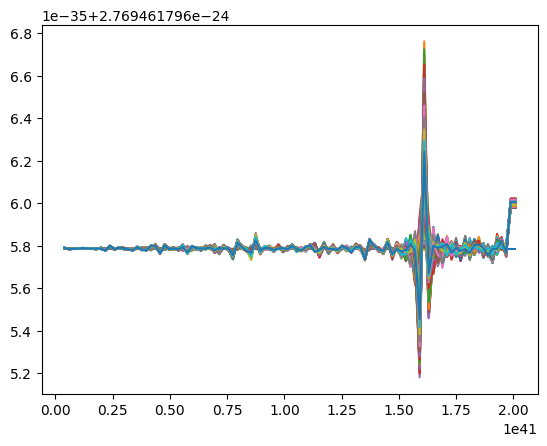

In [10]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 5
for i in range(draw_time_zero, rho.shape[0]-1, draw_time_step):
    ax.plot(M[:], rho[i, :])
plt.show()

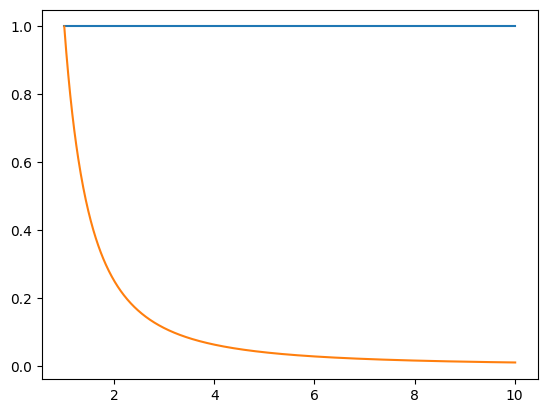

In [11]:
fig, ax = plt.subplots()
hh=1
ax.plot(t_vector[:-hh]/t_vector[0], rho[:-hh-1, 0]/rho[0, -1])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-2)

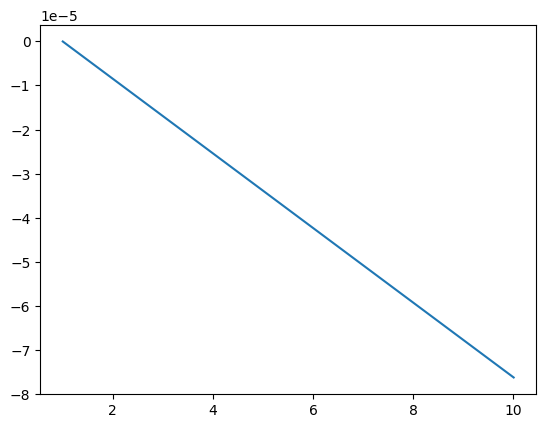

In [12]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, -1])
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.plot(t_vector/t_vector[0],H*r[:-1,-1])

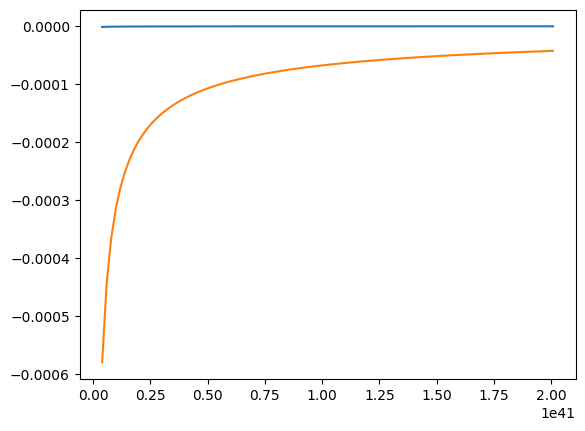

In [13]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 500
for i in range(draw_time_zero, V.shape[0]-2, draw_time_step):
    ax.plot(M[:], V[i+1, :])
plt.show()

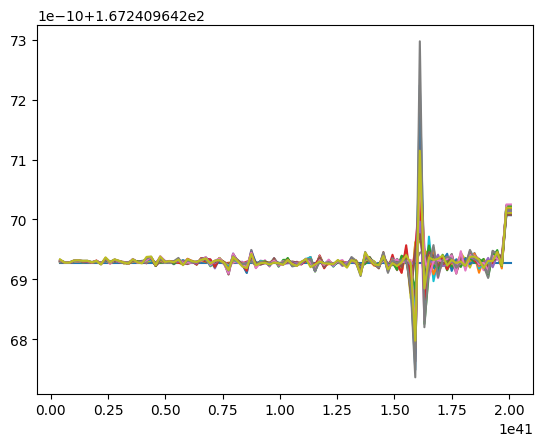

In [14]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, T.shape[0]-1, draw_time_step):
    ax.plot(M[:], T[i, :])
plt.show()

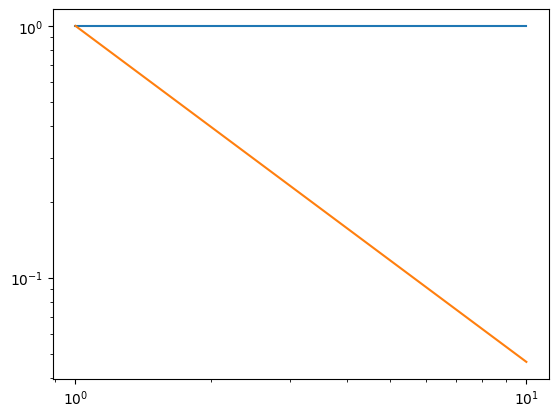

In [15]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], T[:-1, -1]/T[0, -1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-(4/3))

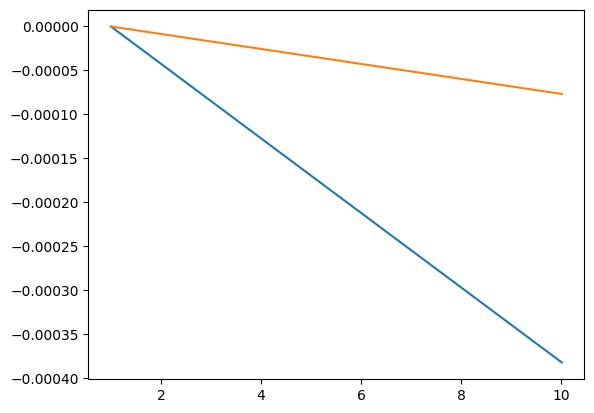

In [16]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, 7])
ax.plot(t_vector/t_vector[0], V[:-1, -2])

Новое

In [17]:
# Расчет профиля плотности ТМ
from scipy.optimize import fsolve

M_sun = 1.98847*1e33 # [g] solar mass
M_pbh = 1e5*M_sun
G = 6.67390*1e-8 # [cm^3 * g^-1 * s^-2]

z = 15
t = z_to_t(z)/(3.17*1e-14)

ti = z_to_t(3119)/(3.17*1e-14)
Hi = 2/(3*ti)

rhoi = Hi**2/(8/3*np.pi*G)

# r_s = (4/3/np.pi)**(8/9)*(5/3)**(1/3)*(3*M_pbh/(4*np.pi*rhoi))**(1/3)*((t-ti)/ti)**(8/9)
r_s = 6.7e22 * (M_pbh/1e9/M_sun)**(1/3)*(1/18+z/18)**(-4/3)
r = np.linspace(r_s/4,200*r_s/4,1000)

def func(theta):
    r_current = rr
    return theta + 0.5*np.sin(2*theta) + np.pi/2*(1 - (r_current/r_s)**(-9/8)*np.cos(theta)**(9/4))

root = np.zeros(r.shape[0])
for i in range(r.shape[0]):
    rr = r[i]
    root[i] = fsolve(func, 0.5)[0]

# здесь искуственная поправка так как этот профиль уходит не в rho_mean а в rho_mean/4 на бесконечности
rho_in_mean_rho = 9/(2*np.cos(root[:])**4)*(root[:]+1/2*np.sin(2*root[:])+np.pi/2)**2/(8*np.cos(root[:])**2+0*np.tan(root[:])*(root[:]+1/2*np.sin(2*root[:])+np.pi/2))

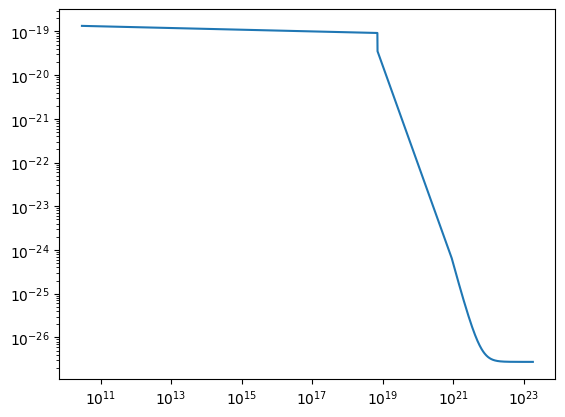

In [18]:
# Задание профиля плотности
# От центра (радиус шварцшильда) до r_c=50*(M_pbh/1e9/M_sun)**(1/3) pc
z_in = 3119
t_in = z_to_t(z_in)/T_s_Myr
H = 2/(3*t_in)
rho_eq = H**2/(8/3*np.pi*G)
r_1 = np.linspace(2.95*(M_pbh/M_sun)*1e5,0.99*50*(M_pbh/1e9/M_sun)**(1/3)*3.08*1e18, 100)
# rho_1 = rho_eq*r_1**(np.log())#*np.ones(len(r_1))#r_1**(-0.115)   # степень тут просто для сшивки

Ht = 2/(3*t)
rhot = Ht**2/(8/3*np.pi*G)

# От r_c до r_virial
r_2 = np.linspace(50*(M_pbh/1e9/M_sun)**(1/3)*3.08*1e18,0.99*r_s/4,1000)
rho_3 = rho_in_mean_rho*rhot
rho_2 = (rho_3[0]/(2.3*1e-17*(M_pbh/1e9/M_sun)**(3/4)*(r[0]/3.08e18)**(-9/4)))*2.3*1e-17*(M_pbh/1e9/M_sun)**(3/4)*(r_2/3.08e18)**(-9/4)  # множитель из условия сшивки
rho_1 = rho_eq*(r_1/r_s)**(np.log(rho_2[0]/rho_eq)/np.log(r_2[0]))  # здесь степень получена из условия сшивки
# дальше r_virial
# r_3 = np.linspace(r_s/4,4*r_s,1000)

r_total = np.append(np.append(r_1,r_2),r)
rho_total = np.append(np.append(rho_1,rho_2),rho_3)
fig, ax = plt.subplots()
# ax.plot(r_1,rho_1)
# ax.plot(r_2,rho_2)
# ax.plot(r,rho_3)
ax.plot(r_total,rho_total)
ax.set_xscale('log')
ax.set_yscale('log')

In [28]:
r_sch = 2.95*(M_pbh/M_sun)*1e5
r_c = 50*(M_pbh/1e9/M_sun)**(1/3)*3.08*1e18

In [20]:
# аппроксимируем плотность (нам нужно аппроксимироват только решение Берштингера тк для двух других частей профиля мы знаем явный вид профиля)
from scipy.optimize import curve_fit

# def func1(x,c1,c2,c3,c4):
#     return c1*x**3 + c2*x**2 + c3*x + c4

def func1(x,c1,c2,c3,c4,c5):
    return c1*np.exp(c4*np.arctan(-c2*x + c3)-c5)

popt, pcov = curve_fit(func1, r/r_s, rho_in_mean_rho)

In [21]:
r_sch = 2.95*(M_pbh/M_sun)*1e5
r_c = 50*(M_pbh/1e9/M_sun)**(1/3)*3.08*1e18
# Плотности умноженные на r**2 заданные как функции радиуса
x1 = lambda x: x**2*rho_eq*x**(np.log(rho_2[0]/rho_eq)/np.log(r_2[0]))
x2 = lambda x: x**2*(rho_3[0]/(2.3*1e-17*(M_pbh/1e9/M_sun)**(3/4)*(r[0]/3.08e18)**(-9/4)))*2.3*1e-17*(M_pbh/1e9/M_sun)**(3/4)*(x/3.08e18)**(-9/4)
x3 = lambda x: x**2*rhot*popt[0]*np.exp(popt[3]*np.arctan(-popt[1]*x + popt[2])-popt[4])

# Массы для 3-х частей профиля плотности
def Mass1(x):
    return integrate.quad(x1,(r_sch+1e-30) + r_sch*(x>r_sch),(r_sch+1e-29) + x*(x>r_sch)*(x<=r_c) + r_c*(x>r_c))[0]
def Mass2(x): # здесь неправильные пределы
    return integrate.quad(x2,(r_c+1e-30) + r_c*(x>r_c),(r_c+1e-29) + x*(x>r_c)*(x<=r_s/4) + r_s/4*(x>r_s/4))[0]
def Mass3(x):
    return integrate.quad(x3,(r_s/4+1e-30) + r_s/4*(x>r_s/4),(r_s/4+1e-29) + x*(x>r_s/4))[0]

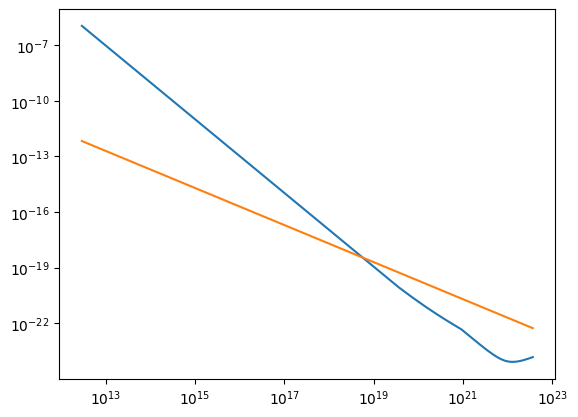

In [22]:
c_s = np.sqrt(5/3*R_gas*1e4)#np.sqrt(kB*10**4/(m_p))
x = np.linspace(100*r_sch,10*r_s,1000)
fig, ax = plt.subplots()
dPhi_dr = np.zeros(len(x))
for i in range(len(x)):
    dPhi_dr[i] = (M_pbh + Mass1(x[i]) + Mass2(x[i]) + Mass3(x[i]))/x[i]**2 *G/c_s**2
ax.plot(x,dPhi_dr)
ax.plot(x,2/x)
ax.set_xscale('log')
ax.set_yscale('log')

In [23]:
# ищем критические точки (выдает три значения, корни от меньшего к большему, если будет находить одинаковые то они будут nan, если корни не найдены то тоже nan)
from scipy.optimize import fsolve
c_s = np.sqrt(5/3*R_gas*1e4)
def funnc(x):
    return 2/x - G/c_s**2*M_pbh/x**2 - G/c_s**2 * (Mass1(x) + Mass2(x) + Mass3(x))/x**2

root_1 = np.nan
root_2 = np.nan
root_3 = np.nan

root_1 = fsolve(funnc,1)
multiplier = 10
if root_1<1e40 and root_1>0:
    root_2 = fsolve(funnc,multiplier*root_1)
    if root_2<1e40 and (root_2-root_1)/root_1>1e-2 and root_2>0:
        root_3 = fsolve(funnc,multiplier*root_2)
        if root_3>1e40 or (root_3-root_1)/root_1<1e-2 or (root_3-root_2)/root_2<1e-5 or root_3<0:
            root_3 = np.nan
    else: root_2=np.nan
# root_2 = fsolve(funnc,multiplier*root_1)
# root_3 = fsolve(funnc,multiplier*root_2)

# print(funnc(root_1)/(2/root_1))
# print(funnc(root_2)/(2/root_2))
if np.abs(funnc(root_1)/(2/root_1))>1e-5:
    root_1 = np.nan
if np.abs(funnc(root_2)/(2/root_2))>1e-5:
    root_2 = np.nan

print(root_1)
print(root_2)
print(root_3)

[4.82072752e+18]
[2.28739679e+23]
nan


In [24]:
rrr = root_1[0]
C = 0.5 - 2*np.log(rrr) - G/c_s**2 * (Mass1(rrr) + Mass2(rrr) + Mass3(rrr))/rrr - G/c_s**2*M_pbh/rrr

In [25]:
r = np.linspace(1e18, 1e20, 10000)
i = 0
MM = np.zeros(r.shape[0])
def loglog(x):   # переопределение логарифма чтобы ошибки не возникали
    return np.log(x*(x>1e-300) + 1e-300*(x<=1e-300))
def func2(M):
    return 0.5*M**2 - loglog(M) + aa
# def func2(M):
#     return 0.5*M**2 - np.log(M) - 10


for i in range(r.shape[0]):
    rr = r[i]
    aa = - 2*loglog(rr) - G/c_s**2 * (Mass1(rr) + Mass2(rr) + Mass3(rr))/rr - G/c_s**2*M_pbh/rr - C
    MM[i] = fsolve(func2, 10)[0]

C:\Users\valt9\PycharmProjects\scientificProject\venv\lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\valt9\PycharmProjects\scientificProject\venv\lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


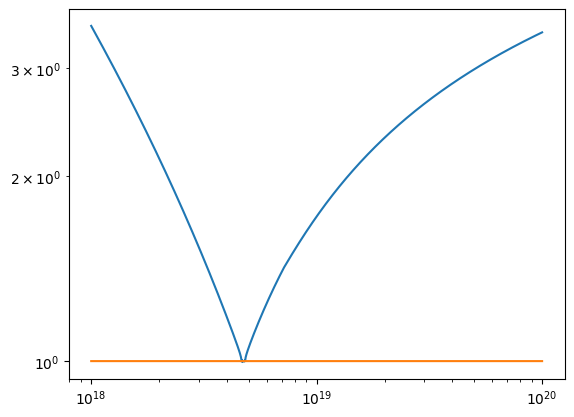

In [26]:
fig, ax = plt.subplots()
ax.plot(r,MM)
ax.plot(r,np.ones(len(r)))
ax.set_xscale('log')
ax.set_yscale('log')

In [27]:
# Блоки для обработки warning как error
# import warnings
# warnings.filterwarnings("error")
# After this you will be able to catch warnings same as errors, e.g. this will work:
#
# try:
#     some_heavy_calculations()
# except RuntimeWarning:
#     breakpoint()

SyntaxError: invalid syntax (455192030.py, line 1)

In [ ]:
rr = 1e18
aa = - 2*loglog(rr) - G/c_s**2 * (Mass1(rr) + Mass2(rr) + Mass3(rr))/rr - G/c_s**2*M_pbh/rr - C
fsolve(func2, 10)[0]

In [ ]:
root_1 = fsolve(funnc,1)

In [ ]:
root_1

In [ ]:
(root_2-root_1)/root_1

In [29]:
# ищем критические точки
from scipy import integrate
from scipy.optimize import fsolve

def funnc(x):
    return 2/(x) - 1/c_s**2*G*M_pbh/x**2 - 1/c_s**2*dPhi_dr3(x)[0]
root_1 = fsolve(funnc,1)

# Задаем потенциал
dPhi_dr =  G*M_pbh/r_total[:-1]**2/c_s**2 + G*MM/(r_total[:-1])**2/c_s**2 #+ G*M_pbh/(r[:-1])**2

NameError: name 'dPhi_dr3' is not defined

In [30]:
funnc(root_1)

NameError: name 'dPhi_dr3' is not defined

ValueError: operands could not be broadcast together with shapes (1000,) (10000,) 

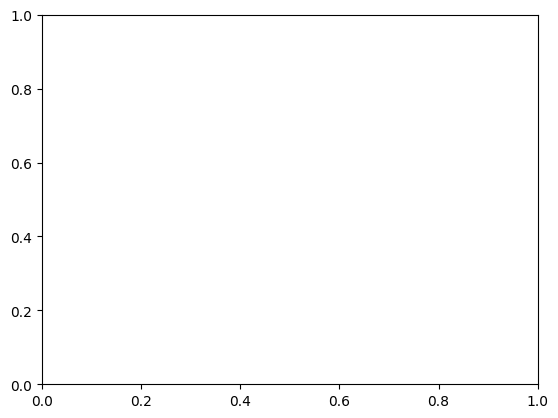

In [31]:
# func1(root_1,*popt)
fig, ax = plt.subplots()
# ax.plot(r/r_s,0.01*func1(r/r_s,*popt))
# ax.plot(r_total/r_s,rho_total/rhot)
ax.plot(r/r_s,rho_in_mean_rho - func1(r/r_s,*popt))
# ax.set_xlim(0,20)
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
from scipy.interpolate import splrep, BSpline

x = r_total/r_s
y = rho_total/rhot

tck = splrep(x, y, s=0)
tck_s = splrep(x, y, s=len(x))

fig, ax = plt.subplots()
# xnew = np.arange(start=r_total[0]/r_s, stop=r_total[-1]/r_s,step=(r_total[1]-r_total[0])/100/r_s)
ax.plot(r_total/r_s, BSpline(*tck)(r_total/r_s), '-', label='s=0')
# ax.set_xlim(0,20)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label=f's={len(x)}')
# plt.plot(x, y)
# plt.legend()
# plt.show()

In [32]:
# # сшиваем с профилем -9/4 внутри r_virial
# k = rho_in_mean_rho[0]*(r[0])**(9/4)
# r_inside_virial = np.linspace(1e18,r[0],1000)
# rho_in_mean_rho = np.append(k*r_inside_virial**(-9/4),rho_in_mean_rho)
# r = np.append(r_inside_virial,r)

In [33]:
# 3*M_pbh/(4*np.pi*rhoi))**(1/3)

In [34]:
c_s = np.sqrt(5/3*R_gas*1e4)#np.sqrt(5/3*10**4/(m_p))
from md import *

# M_halo = np.sum(rho_in_mean_rho[:-1]*rhot*4/3*np.pi*(r[1:]**3 - r[:-1]**3))
M_halo = mdmt(r[-1]/r_s) * (rhot*4*np.pi/3*r_s**3)
beta = M_pbh/M_halo
lh = G*M_halo/c_s**2
alpha = r_s/4/lh
# alpha = 0.1
# M_pbh = beta * M_halo
# a = alpha*lh

In [35]:
print(alpha)
print(beta)

30.05853337588836
0.31646298023335984


In [36]:
from md import *
# G*mdmt(r/r_s)/r * (rhot*4*np.pi/3*r_s**3)

In [37]:
# Ищем критические точки
# Задаем массу для потенциала
MM = np.zeros(rho_total.shape[0]-1)
for i in range(1,MM.shape[0]+1):
    V = 4/3*np.pi*((r_total[1:])**3 - (r_total[:-1])**3)
    MM[i-1] = np.sum(rho_total[0:i]*V[0:i])

# Задаем потенциал
dPhi_dr =  G*M_pbh/r_total[:-1]**2/c_s**2 + G*MM/(r_total[:-1])**2/c_s**2 #+ G*M_pbh/(r[:-1])**2

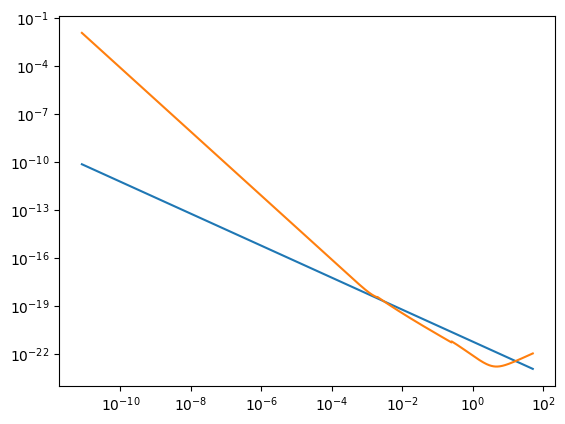

In [38]:
fig, ax = plt.subplots()
ax.plot(r_total/r_s,2/r_total)
ax.plot(r_total[:-1]/r_s,dPhi_dr)
ax.set_xscale('log')
ax.set_yscale('log')

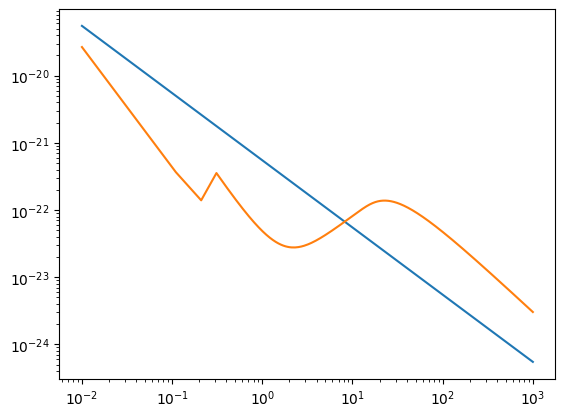

In [39]:
r = np.linspace(r_s/100,1000*r_s,10000)
fig, ax = plt.subplots()
ax.plot(r[:-1]/r_s,2/r[:-1])
# ax.plot(r[:-1],dPhi_dr)
ax.plot(r/r_s,1/c_s**2 * G*M_pbh/r**2 + 1/c_s**2 * G*mdmt(r/r_s)/r**2 * (rhot*4*np.pi/3*r_s**3))
ax.set_xscale('log')
ax.set_yscale('log')

In [40]:
r = np.linspace(r_s,10000*r_s,1000000)

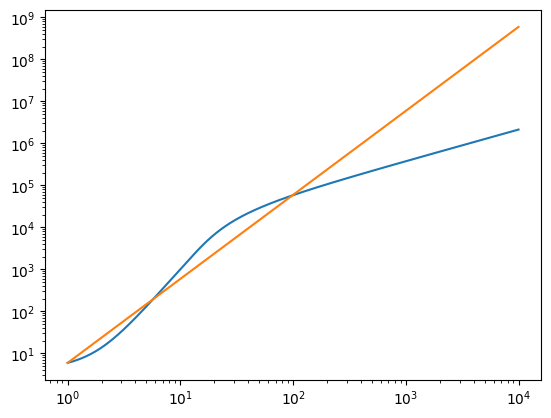

In [41]:
fig, ax = plt.subplots()
ax.plot(r/r_s,mdmt(r/r_s))
ax.plot(r/r_s,r**2*mdmt(1)/r_s**2)
ax.set_xscale('log')
ax.set_yscale('log')

Хернквист

In [42]:
# крит точки для профиля хернквиста
c_s = np.sqrt(5/3*R_gas*1e4)#np.sqrt(kB*10**4/(m_p))
M_halo = 1e5*M_sun
lh = G*M_halo/c_s**2
alpha = 0.01
beta = 1e-6
# alpha = 2/(4*np.log(2/beta)-3)
M_pbh = beta * M_halo
a = alpha*lh
def funnc(x):
    return 2/(x) - 1/c_s**2 * G*M_pbh/x**2 - G*M_halo/(c_s**2*(x+a)**2)

root_1 = fsolve(funnc,0.001)
print(root_1)

# нахождение корней корней работает довольно точно (при alpha=0.125 один корень, а при alpha<=0.124 два корня как и должно быть), но иногда корни могут сливаться (то есть один из них не будет найден), это зависит от выбора множителя перед вторым параметром в fsolve (который первоначальная догадка о корне и который стоит в root_2 и root_3). Если брать этот множитель брать слишком малым то корни будут сливаться, если слишком большим то корни будут уходить на бесконечность (то есть промахиваться по реальному корню)
# if root_1>1e40:
#     выкидываем root_1 и дальше не продолжаем (корней нет)
multiplier = 10 # Должен быть больше 1 либо другие корни не будет найдены

root_2 = fsolve(funnc,multiplier*root_1)
print(root_2)

# if root_2>1e40 or root_2==root_1:
#     выкидываем root_2 и дальше не продолжаем (корень один и он root_1)
#     либо мы промахнулись по корню (множитель неправильный)
root_3 = fsolve(funnc,multiplier*root_2)
print(root_3)

# if root_3 > 1e40 or root_3==root_2:
#     выкидываем root_3 (корней 2 и это root_1 и root_2)
#     либо мы промахнулись по корню (множитель неправильный)

# нужно сделать цикл пробегающий по значениям множителя и определяющий оптимальный

[4.80064613e+12]
[1.99111873e+15]
[4.59507981e+18]


In [43]:
rrr = root_3
C = 0.5 - 2*loglog(rrr/lh) - lh/(rrr + a) - beta*lh/rrr
print(C)

[-0.07287988]


In [44]:
r = np.linspace(1e12, 1e13, 50000)
i = 0
MM = np.zeros(r.shape[0])
def loglog(x):   # переопределение логарифма чтобы ошибки не возникали
    return np.log(x*(x>1e-300) + 1e-300*(x<=1e-300))
def func2(M):
    return 0.5*M**2 - loglog(M) - 2*loglog(rr/lh) - lh/(rr + a) - beta*lh/rr - C[0]
# def func2(M):
#     return 0.5*M**2 - np.log(M) - 10

for i in range(r.shape[0]):
    rr = r[i]
    MM[i] = fsolve(func2, 10)[0]

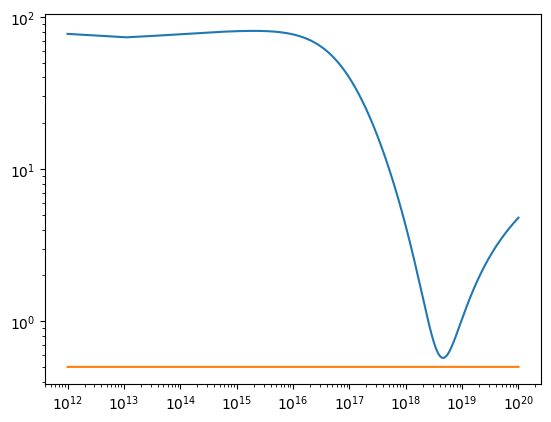

In [45]:
rr = np.linspace(1e12,1e20,10000000)
fig, ax = plt.subplots()
ax.plot(rr,2*loglog(rr/lh) + lh/(rr + a) + beta*lh/rr)
ax.plot(rr,0.5*np.ones(len(rr)))
ax.set_xscale('log')
ax.set_yscale('log')

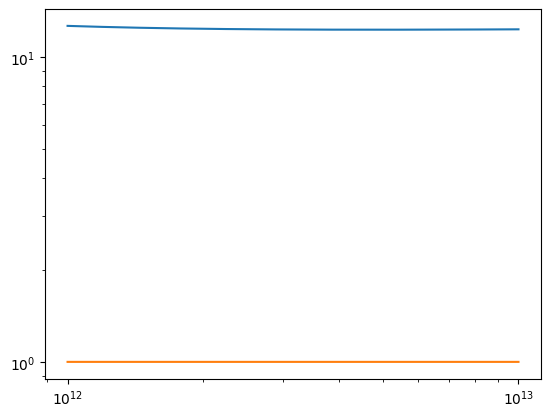

In [46]:
fig, ax = plt.subplots()
ax.plot(r,MM)
ax.plot(r,np.ones(len(r)))
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
# r = np.linspace(1e12,1e19,10000)
# i = 0
# C = np.zeros(20)
# MM = np.zeros((C.shape[0],r.shape[0]))
# C[0] = -5
# for j in range(C.shape[0]-1):
#     def func2(M):
#         rr = r[i]
#         CC = C[j]
#         # CC = 5
#         return 0.5*M**2 - np.log(M*(M>0) + 0.00001*(M<=0)) - 2*np.log(rr/lh) - lh/(rr+a) - beta*lh/rr - CC
#     for i in range(r.shape[0]):
#         MM[j,i] = fsolve(func2,10)
#     C[j+1] = C[j]-5

In [ ]:
root_1

In [ ]:
fig, ax = plt.subplots()
Font = 16
for i in range(C.shape[0]):
    ax.plot(r,MM[i,:],label=f"C = {int(C[i])}")
ax.legend(fontsize = Font)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
MM = np.linspace(0.00000000001,50,10000)
fig, ax = plt.subplots()
ax.plot(MM,0.5*MM**2 - np.log(MM))
i = 0
rr = r[i]
C = -85
ax.plot(MM,np.ones(MM.shape[0])*2*np.log(rr/lh) + lh/(rr+a) + C)
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
2*np.log(rr/lh) + lh/(rr+a) + C

In [ ]:
r = np.linspace(1e9,1e19,1000000)

In [ ]:
fig, ax = plt.subplots()
ax.plot(r,2/r)
# M_halo = 1e5*M_sun
# lh = G*M_halo/c_s**2
# alpha = 1e-21
# beta = 1e-26
# M_pbh = beta * M_halo
# a = alpha*lh
ax.plot(r,1/c_s**2 * G*M_pbh/r**2 + G*M_halo/(c_s**2*(r+a)**2))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.plot(r,2/r**2)

In [ ]:
fig, ax = plt.subplots()
ax.plot(r,2/r - G*1e5*M_sun/(c_s**2*(r+a)**2))
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim(-0.5e-18,0.5e-18)
ax.plot(r,np.zeros(r.shape[0]))

In [ ]:
fig, ax = plt.subplots()
ax.plot(r[:-1],func1(r[:-1],*popt))
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r[:-1],funn/funn[0])

In [ ]:
fig, ax = plt.subplots()
ax.plot(r[:-1],funn/funn[0])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r[:-1],popt[1]*(r[:-1])**(popt[0]))

In [ ]:
def funnn1(x,a,k):
    return K*x**a

popt, pcov = curve_fit(funnn1, r[:-1], )

In [ ]:
popt

In [ ]:
from scipy.optimize import curve_fit

def funnn(x,a,k):
    return k*x**a

xdata = r/r[0]
# ydata = (r/r_s)**(-9/4)
ydata = rho_in_mean_rho
popt, pcov = curve_fit(funnn, xdata, ydata)

In [ ]:
r = np.linspace(1e10,1e25)

In [ ]:
rho_in_mean_rho

In [ ]:
from scipy.optimize import curve_fit
# x = np.linspace(1000,10000,10000)
x = r/r[0]
y = x**(-9/4)

def funnn(x,a,k):
    return k*x**a

rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=x.size)
ydata = y

popt, pcov = curve_fit(funnn, x, y, )

In [ ]:
r/r[0]

In [ ]:
popt

In [ ]:
import numpy as np
from scipy.interpolate import splrep, BSpline

x = r
y = rho_in_mean_rho

tck = splrep(x, y, s=0)
tck_s = splrep(x, y, s=len(x))

import matplotlib.pyplot as plt
xnew = np.arange(start=r[0], stop=r[-1],step=(r[1]-r[0])/100)
plt.plot(xnew, BSpline(*tck)(xnew), '-', label='s=0')
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label=f's={len(x)}')
plt.plot(x, y)
plt.legend()
plt.show()

In [ ]:
x = np.linspace(0.001,100,1000)
y = np.log(x)

tck = splrep(x, y, s=0)
tck_s = splrep(x, y, s=len(x))

import matplotlib.pyplot as plt
# plt.plot(xnew, BSpline(*tck)(xnew), '-', label='s=0')
plt.plot(x, BSpline(*tck_s)(x), '-', label=f's={len(x)}')
plt.plot(x, y)
plt.legend()
plt.show()

In [ ]:
def loglog(x):
    return np.log(x*(x>1e-300) + 1e-300*(x<=1e-300))

In [ ]:
loglog(1e-699)

In [ ]:
np.log(1e-300)

In [ ]:
plt.plot(xnew, BSpline(*tck_s)(xnew))

In [ ]:
plt.loglog(xnew, BSpline(*tck)(xnew), '-', label='s=0')

In [ ]:
from scipy.optimize import curve_fit

def funnn(x,a,k):
    return k*x**a

xdata = xnew
ydata = BSpline(*tck)(xnew)
popt, pcov = curve_fit(funnn, xdata, ydata)

In [ ]:
# x[i+1] = x[i] + f(x[i])
def func5(x):
    return x**2*(x>0) + (x>0)*np.log(x) - 55

n = 4
x = np.zeros(n+1)
x[0] = 100
tau = -1
for i in range(n):
    x[i+1] = x[i] + tau*func5(x[i])